## Deterministic vs. Bayesian (Laplace approximation) neural networks on flat and hierarchical toy data

In [8]:
import numpy as np
import matplotlib.pyplot as plt

## Data: flat or hierarchical

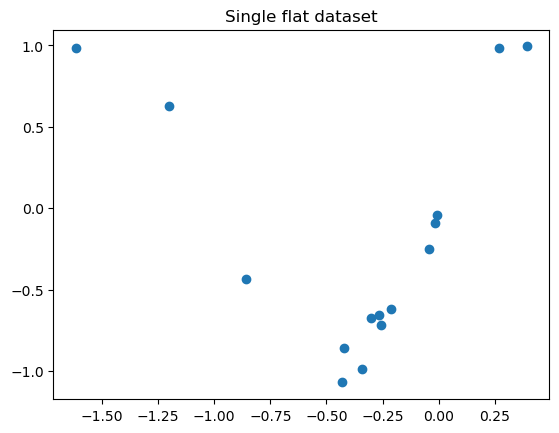

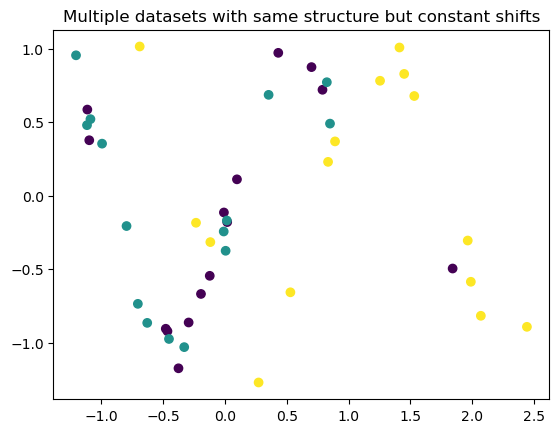

In [112]:
def sample_uneven_distribution(n_samples):
    mean1, mean2 = np.random.uniform(-1, 1, 2)
    ratio = np.random.uniform(0.5, 0.8)
    n1 = int(n_samples * ratio)
    n2 = n_samples - n1
    X1 = np.random.normal(mean1, 0.5, n1)
    X2 = np.random.normal(mean2, 0.5, n2)
    X = np.concatenate((X1, X2))
    return X.reshape(-1, 1)


def generate_flat_data(n_samples):
    X = sample_uneven_distribution(n_samples)
    Y = np.sin(X * np.pi) + np.random.normal(0, 0.1, X.shape)
    return X.astype(np.float32), Y.astype(np.float32)


def generate_hierarchical_data(n_samples_per_group, n_groups):
    X = np.empty((0, 1))
    Y = np.empty((0, 1))
    group = np.array([])

    for i in range(n_groups):
        X_group, Y_group = generate_flat_data(n_samples_per_group)
        X_group += np.random.uniform(0, 1)

        X = np.concatenate((X, X_group), axis=0)
        Y = np.concatenate((Y, Y_group), axis=0)
        group = np.append(group, np.full(n_samples_per_group, i))

    return X.astype(np.float32), Y.astype(np.float32), group.astype(int)


X, Y = generate_flat_data(15)
plt.scatter(X, Y)
plt.title("Single flat dataset")
plt.show()

X, Y, group = generate_hierarchical_data(15, 3)
plt.scatter(X, Y, c=group)
plt.title("Multiple datasets with same structure but constant shifts")
plt.show()

## Deterministic neural networks

In [114]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam

import pytorch_lightning as pl
from pytorch_lightning.callbacks import Callback

#### Flat models

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type    | Params
----------------------------------
0 | model | Network | 481   
----------------------------------
481       Trainable params
0         Non-trainable params
481       Total params
0.002     Total estimated model params size (MB)


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


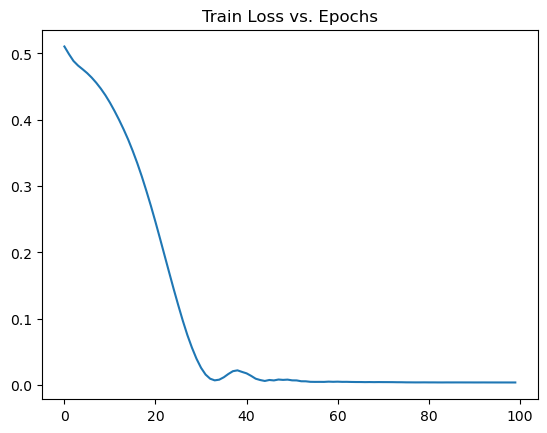

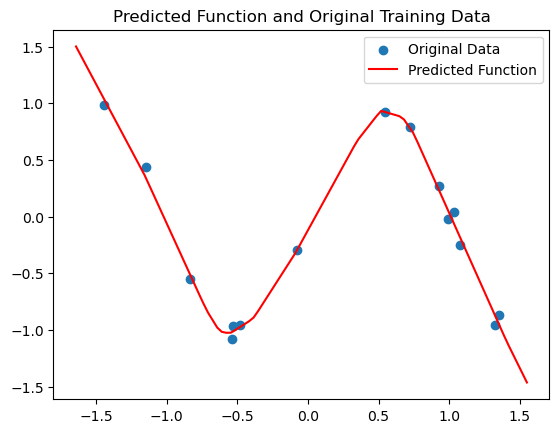

In [124]:
class DataModule(pl.LightningDataModule):
    def __init__(self, X, Y, batch_size=32):
        super().__init__()
        self.X = torch.tensor(X)
        self.Y = torch.tensor(Y)
        self.batch_size = batch_size

    def train_dataloader(self):
        dataset = TensorDataset(self.X, self.Y)
        return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)


class Network(nn.Module):
    def __init__(self, hidden_dim=20, n_layers=2):
        super().__init__()

        hidden_layers = [nn.Linear(hidden_dim, hidden_dim), nn.ReLU()] * (n_layers - 1)
        self.layers = nn.ModuleList(
            [
                nn.Linear(1, hidden_dim),
                nn.ReLU(),
                *hidden_layers,
                nn.Linear(hidden_dim, 1),
            ]
        )

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class LightningModule(pl.LightningModule):
    def __init__(self, model, learning_rate):
        super().__init__()
        self.model = model

        self.learning_rate = learning_rate

    def configure_optimizers(self):
        return Adam(self.model.parameters(), lr=self.learning_rate)

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self.model(x)
        loss = F.mse_loss(y_hat, y)
        self.log("train_loss", loss)
        return loss


class LogTrainErrorCallback(Callback):
    def __init__(self):
        self.train_losses = []
    def on_train_epoch_end(self, trainer, pl_module):
        train_loss = pl_module.trainer.logged_metrics["train_loss"]
        self.train_losses.append(train_loss)

    def on_fit_end(self, trainer, pl_module):
        plt.plot(self.train_losses)
        plt.title("Train Loss vs. Epochs")
        plt.show()


class PlotPredictionCallback(Callback):
    def __init__(self, X, Y):
        self.X = X
        self.Y = Y

    def on_fit_end(self, trainer, pl_module):
        grid = torch.linspace(
            np.min(self.X) - 0.2, np.max(self.X) + 0.2, 100
        ).unsqueeze(1)

        pl_module.model.eval()
        with torch.no_grad():
            predictions = pl_module.model(grid).numpy()

        plt.scatter(self.X, self.Y, label="Original Data")
        plt.plot(grid.numpy(), predictions, label="Predicted Function", color="red")
        plt.legend()
        plt.title("Predicted Function and Original Training Data")
        plt.show()


N_SAMPLES = 15
LEARNING_RATE = 1e-2
MAX_EPOCHS = 100

X, Y = generate_flat_data(N_SAMPLES)
data_module = DataModule(X, Y)
model = Network()
lightning_module = LightningModule(model, LEARNING_RATE)

trainer = pl.Trainer(
    max_epochs=MAX_EPOCHS,
    callbacks=[LogTrainErrorCallback(), PlotPredictionCallback(X, Y)],
)
trainer.fit(lightning_module, data_module)